In [1]:
# Command to mount gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Command to upload file from local drive

from google.colab import files
uploaded = files.upload()

Saving utils.py to utils.py


In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import glob
import keras
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#from vgg16 import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
#from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
#from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box


Using TensorFlow backend.


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2580480/45929032 bytes (5.6%)6807552/45929032 bytes (14.8%)10993664/45929032 bytes (23.9%)15269888/45929032 bytes (33.2%)19464192/45929032 bytes (42.4%)23617536/45929032 bytes (51.4%)27869184/45929032 bytes (60.7%)31981568/45929032 bytes (69.6%)36192256/45929032 bytes (78.8%)40312832/45929032 bytes (87.8%)44605440/45929032 bytes (97.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [3]:
# Function to create model

%reset
%matplotlib inline

from keras import models
from keras import layers
from keras.layers.advanced_activations import LeakyReLU

def create_yolov1_tiny_model(shape):
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Dense(4096))
    model.add(LeakyReLU(0.1))
    model.add(layers.Dense(1470))
    
    return model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
# Function to create bounding boxes

def to_bounding_boxes(result, threshold = 0.17):
    grid_size = 7
    num_classes = 20
    num_boxes_per_cell = 2

    predictions = result[:grid_size * grid_size * num_classes]
    assert len(predictions) == 980

    confidences = result[len(predictions) : len(predictions) + grid_size * grid_size * num_boxes_per_cell]
    assert len(confidences) == 98

    coordinates = result[len(predictions) + len(confidences):]
    assert len(coordinates) == 392

    predictions = predictions.reshape([grid_size * grid_size, num_classes])
    confidences = confidences.reshape([grid_size * grid_size, num_boxes_per_cell])
    coordinates = coordinates.reshape([grid_size * grid_size, 2, 4])
    
    boxes = []

    cell_dim = 1. / grid_size

    for cell_i in range(grid_size * grid_size):
        for box_i in range(num_boxes_per_cell):
            grid_row = cell_i // grid_size
            grid_column = cell_i % grid_size

            x, y, width, height = coordinates[cell_i, box_i]

            # We parametrize the bounding box x and y coordinates to be offsets of a particular grid cell location so they are also bounded between 0 and 1
            x = (grid_column * cell_dim) + (x * cell_dim)
            y = (grid_row * cell_dim) + (y * cell_dim)

            # We normalize the bounding box width and height by the image width and height so that they fall between 0 and 1.        
            # This should really be **2, but the original implementation uses **1.8. No idea why though...
            width = width ** 1.8
            height = height ** 1.8

            box_confidence = confidences[cell_i, box_i]

            highest_class_probability_index = np.argmax(predictions[cell_i])
            highest_class_probability = predictions[cell_i, highest_class_probability_index]

            class_confidence = box_confidence * highest_class_probability

            if class_confidence >= threshold:
                boxes.append(np.array([
                    x-(width/2), y-(height/2.), x+(width/2), y+(height/2.),
                    class_confidence, highest_class_probability_index]))
                
    return np.array(boxes)

In [0]:
def non_maximum_suppression(boxes, threshold, epsilon=0.0001):
    if len(boxes) == 0:
        return []
    
    picks = []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    c = boxes[:, 4]
    
    area = (x2 - x1 + epsilon) * (y2 - y2 + epsilon) 
    idxs = np.argsort(c)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        picks.append(i)
        
        others = idxs[:last]
        xx1 = np.maximum(x1[i], x1[others])
        yy1 = np.maximum(y1[i], y1[others])
        xx2 = np.minimum(x2[i], x2[others])
        yy2 = np.minimum(y2[i], y2[others])

        w = np.maximum(0, xx2 - xx1 + epsilon)
        h = np.maximum(0, yy2 - yy1 + epsilon)
        
        overlap = (w * h) / area[others]
        
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))

    return boxes[picks]

In [0]:
import cv2

def mark_objects(boxes, image):
    h, w, _ = image.shape

    for b in boxes:
        x1, y1, x2, y2, confidence, class_index = b
        
        left  = int (x1 * w)
        right = int (x2 * w)
        top   = int (y1 * h)
        bot   = int (y2 * h)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(image, (left, top), (right, bot), (255,220,0), thick)

    return image

In [7]:
from keras import backend as K
import numpy as np

def load_weights(model,yolo_weight_file):
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
 
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            
            # had to add this to accomodate the new weights structure for conv layers since Keras 2.x
            if(len(kshape) == 4):
                kshape = (kshape[3], kshape[2], kshape[0], kshape[1])
            
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            
            # had to add this to accomodate the new weights structure for conv layers since Keras 2.x
            if(len(kshape) == 4):
                ker = np.transpose(ker,(2, 3, 1, 0))
            
            layer.set_weights([ker,bia])

K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')
th_model = create_yolov1_tiny_model((3, 448, 448))

load_weights(th_model, 'gdrive/My Drive/Colab Notebooks/yolo-tiny.weights') # darknet weights
th_model.save_weights('yolo-tiny_th.weights', overwrite=True)  # keras theano weights
load_weights(th_model,'gdrive/My Drive/Colab Notebooks/yolo-tiny.weights')

K.set_image_dim_ordering('tf')
K.set_image_data_format('channels_last')
tf_model = create_yolov1_tiny_model((448, 448, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def shuffle_rows(original_w, nb_last_conv, nb_rows_dense):
    ''' Note :
    This algorithm to shuffle dense layer rows was provided by Kent Sommers (@kentsommer)
    in a gist : https://gist.github.com/kentsommer/e872f65926f1a607b94c2b464a63d0d3
    '''
    converted_w = np.zeros(original_w.shape)
    count = 0
    for index in range(original_w.shape[0]):
        if (index % nb_last_conv) == 0 and index != 0:
            count += 1
        new_index = ((index % nb_last_conv) * nb_rows_dense) + count
        converted_w[index] = original_w[new_index]

    return converted_w

In [0]:
is_first_dense = True
nb_last_conv = 0

for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ in ['Conv2D']:
        # No change. Conv2D weights always have tensorflow ordering since Keras 2.x
        weights = th_layer.get_weights()
        tf_layer.set_weights(weights)
        
        nb_last_conv = th_layer.filters
    elif th_layer.__class__.__name__ in ['Dense']:
        if is_first_dense:
            is_first_dense = False
            weights = th_layer.get_weights()
            
            nb_rows_dense_layer = weights[0].shape[0] // nb_last_conv
            weights[0] = shuffle_rows(weights[0], nb_last_conv, nb_rows_dense_layer)
            
            tf_layer.set_weights(weights)
        else:
            tf_layer.set_weights(th_layer.get_weights())
            
tf_model.save_weights('yolo-tiny_tf.weights', overwrite=True)

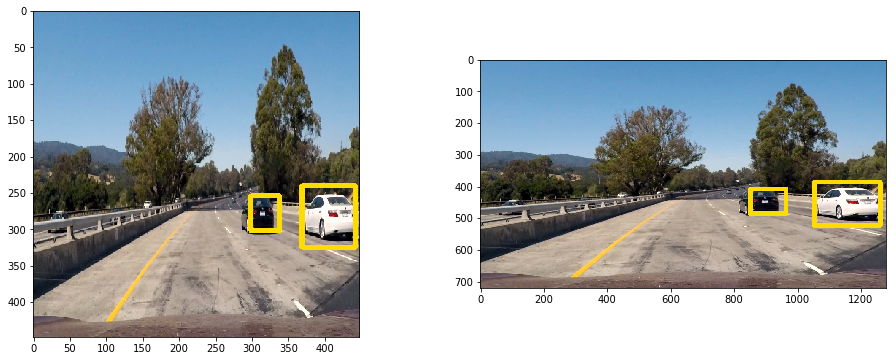

In [10]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
image_path = 'gdrive/My Drive/Colab Notebooks/test1.jpg'

image = load_img(image_path, grayscale=False)
original_image = np.array(image)
resized_image = np.array(image.resize((448, 448)))

batch = np.array(resized_image)
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)

out = tf_model.predict(batch)
boxes = to_bounding_boxes(out[0], threshold=0.17)
boxes = non_maximum_suppression(boxes, 0.4)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(mark_objects(boxes, resized_image))
ax2.imshow(mark_objects(boxes, original_image));

In [11]:
# This section is for multiple images

import cv2
import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

images = [plt.imread(file) for file in glob.glob('gdrive/My Drive/Colab Notebooks/*.jpg')]

#images = load_img('gdrive/My Drive/Colab Notebooks/*', grayscale=False)
for image in images:
  original_image = np.array(image)
  resized_image = cv2.resize(original_image,(448,448)) #np.array(image.resize((448, 448)))

  batch = np.array(resized_image)
  batch = 2*(batch/255.) - 1
  batch = np.expand_dims(batch, axis=0)

  out = tf_model.predict(batch)
  boxes = to_bounding_boxes(out[0], threshold=0.17)
  boxes = non_maximum_suppression(boxes, 0.4)

  f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
  ax1.imshow(mark_objects(boxes, resized_image))
  ax2.imshow(mark_objects(boxes, original_image));

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# This section is for video

def frame_func(image):
    #crop = image[300:650,500:,:]
    #resized = cv2.resize(crop,(448,448))
    
    crop = np.array(image)
    resized = cv2.resize(crop,(448,448))
    
    #batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = np.array(resized)
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    
    out = tf_model.predict(batch)
    boxes = to_bounding_boxes(out[0], threshold=0.17) # threshold changed from .17
    boxes = non_maximum_suppression(boxes, 0.4)
    
    #a = draw_box(boxes,image,[[500,1280],[300,650]])
    #if (a.any()):
    #plt.imshow(a)
     #plt.show()
    return mark_objects(boxes,image)
  


In [0]:
# Location of input video file and the output file to be saved

from moviepy.editor import VideoFileClip
project_video_output = 'gdrive/My Drive/Colab Notebooks/project_video_output.mp4'
clip1 = VideoFileClip('gdrive/My Drive/Colab Notebooks/project_video.mp4')

In [14]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video gdrive/My Drive/Colab Notebooks/project_video_output.mp4
[MoviePy] Writing video gdrive/My Drive/Colab Notebooks/project_video_output.mp4


100%|█████████▉| 1260/1261 [01:46<00:00, 13.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: gdrive/My Drive/Colab Notebooks/project_video_output.mp4 

CPU times: user 26.6 s, sys: 4.59 s, total: 31.2 s
Wall time: 1min 48s
